(60, 20) (60, 20)


<Figure size 432x288 with 0 Axes>

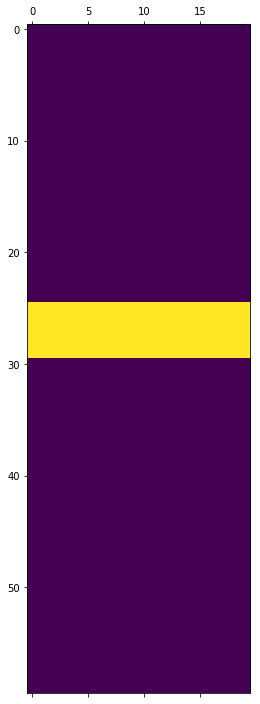

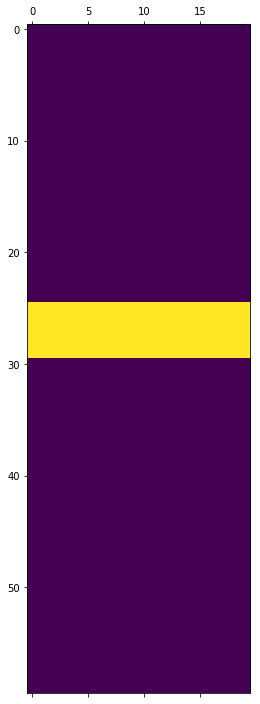

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

MAX_WIDTH = 20
MAX_HEIGHT = 60
MAX_NUM_REGIONS = 3
REGION_HEIGHT = 5
NUM_TO_GENERATE = 100
    
    
def generate_regions(num_regions):
    regions = []
    min_height = 0
    for ind in range(num_regions):
        y1 = np.random.randint(min_height, MAX_HEIGHT - REGION_HEIGHT)
        y2 = y1 + REGION_HEIGHT
        if y2 >= MAX_HEIGHT - REGION_HEIGHT:
            return False
        regions.append((y1, y2))
        min_height = y2
    return regions


def generate_input_and_gt():
#     np.random.seed(42)
    gt_image = np.zeros((MAX_HEIGHT, MAX_WIDTH), dtype=np.uint8)
    num_regions = np.random.randint(MAX_NUM_REGIONS) + 1
    regions = generate_regions(num_regions)
    while not regions:
        regions = generate_regions(num_regions)
    for ind, region in enumerate(regions):
        y1, y2 = region
        gt_image[y1:y2] = ind + 1
    input_image = gt_image > 0
    return input_image, gt_image
    
    
input_image, gt_image = generate_input_and_gt()
print(input_image.shape, gt_image.shape)
plt.figure()
plt.matshow(input_image)
plt.matshow(gt_image)

In [2]:
from tensorflow.keras.utils import to_categorical

BATCH_SIZE = 64
NUM_BATCHES = 1

X = []
Y = []
for _ in range(BATCH_SIZE * NUM_BATCHES):
    input_image, gt_image = generate_input_and_gt()
    X.append(input_image)
    Y.append(to_categorical(gt_image.flatten(), MAX_NUM_REGIONS + 1))
X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

(64, 60, 20) (64, 1200, 4)


In [ ]:
# TODO

class DataSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 60, 20)       0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 60, 20, 2)    0           input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 60, 20, 32)   608         lambda_13[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 60, 20, 32)   9248        conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_59 

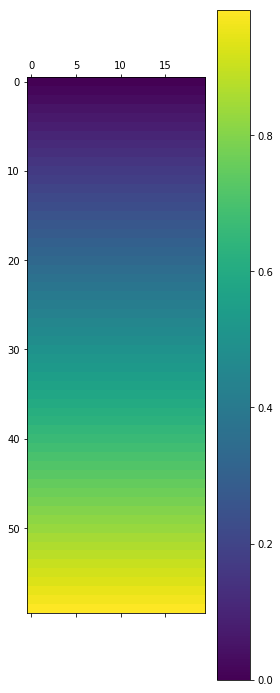

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Conv2D, Dense, Flatten, Input, Lambda, LSTM, MaxPooling2D, Reshape
from tensorflow.keras import backend as K
import tensorflow as tf

M = np.ones((MAX_HEIGHT, MAX_WIDTH))
height = np.arange(MAX_HEIGHT) / MAX_HEIGHT
M = M * np.expand_dims(height, 1)

plt.matshow(M)
plt.colorbar()

M = M.reshape((1, MAX_HEIGHT, MAX_WIDTH, 1))
M = K.variable(M)

input_image = Input((MAX_HEIGHT, MAX_WIDTH))
input_image_with_height = Lambda(
    lambda x: K.concatenate(
        [K.expand_dims(x, -1), tf.tile(M, (K.shape(x)[0], 1, 1, 1))],
        axis=-1
    )
)(input_image)

conv1 = Conv2D(32, kernel_size=(3, 3), dilation_rate=2, padding='same', activation='relu')(input_image_with_height)
conv2 = Conv2D(32, kernel_size=(3, 3), dilation_rate=2, padding='same', activation='relu')(conv1)
output_image = Conv2D(MAX_NUM_REGIONS + 1, kernel_size=(3, 3), dilation_rate=2, padding='same', activation='relu')(conv2)

next_input_image = Concatenate()([input_image_with_height, output_image])
conv3 = Conv2D(32, kernel_size=(3, 3), dilation_rate=2, padding='same', activation='relu')(next_input_image)
conv4 = Conv2D(32, kernel_size=(3, 3), dilation_rate=2, padding='same', activation='relu')(conv3)
output_image2 = Conv2D(MAX_NUM_REGIONS + 1, kernel_size=(3, 3), dilation_rate=2, padding='same', activation='relu')(conv4)

next_input_image2 = Concatenate()([input_image_with_height, output_image2])
conv5 = Conv2D(32, kernel_size=(3, 3), dilation_rate=2, padding='same', activation='relu')(next_input_image2)
conv6 = Conv2D(32, kernel_size=(3, 3), dilation_rate=2, padding='same', activation='relu')(conv5)
output_image3 = Conv2D(MAX_NUM_REGIONS + 1, kernel_size=(3, 3), dilation_rate=2, padding='same', activation='relu')(conv6)

next_input_image3 = Concatenate()([input_image_with_height, output_image3])
conv7 = Conv2D(32, kernel_size=(3, 3), dilation_rate=2, padding='same', activation='relu')(next_input_image3)
conv8 = Conv2D(32, kernel_size=(3, 3), dilation_rate=2, padding='same', activation='relu')(conv7)
output_image4 = Conv2D(MAX_NUM_REGIONS + 1, kernel_size=(3, 3), dilation_rate=2, padding='same', activation='softmax')(conv8)

output_vector = Reshape((MAX_HEIGHT * MAX_WIDTH, MAX_NUM_REGIONS + 1))(output_image4)
model = Model(inputs=input_image, outputs=output_vector)
model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(X.shape, Y.shape)
model.fit(x=X, y=Y, epochs=10, steps_per_epoch=10)

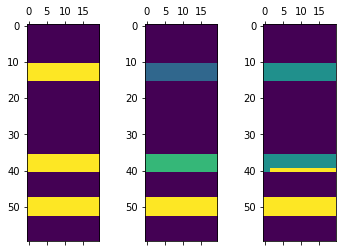

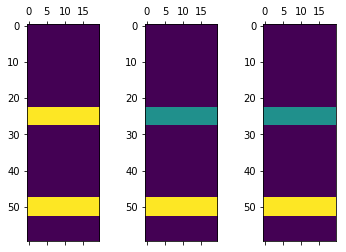

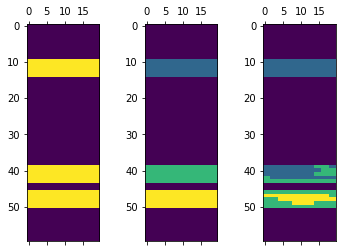

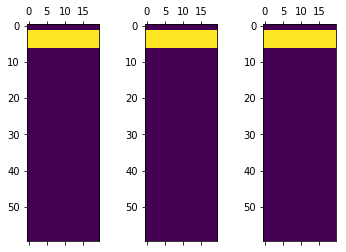

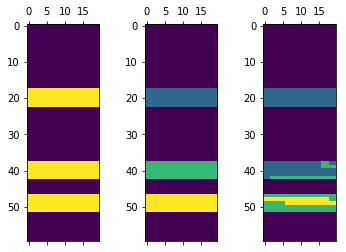

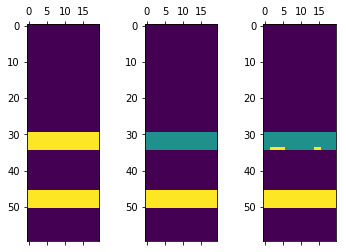

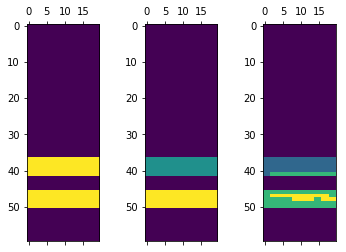

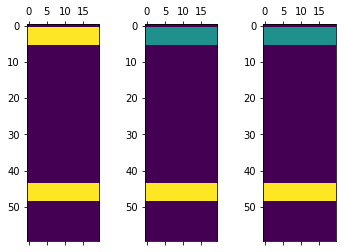

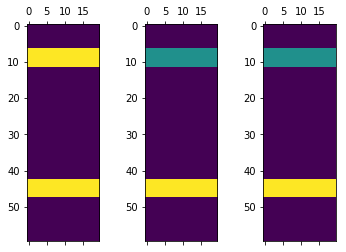

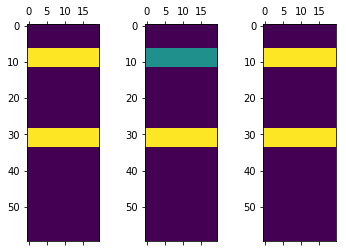

In [17]:
def plot_gt_and_pred(ind):
    sample_input = np.expand_dims(X[ind], 0)
    gt = Y[ind].reshape(MAX_HEIGHT, MAX_WIDTH, -1).argmax(-1)
    pred = model.predict(sample_input).reshape(MAX_HEIGHT, MAX_WIDTH, -1).argmax(-1)
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax1.matshow(X[ind].squeeze())
    ax2 = fig.add_subplot(132)
    ax2.matshow(gt)
    ax3 = fig.add_subplot(133)
    ax3.matshow(pred)
    
for ind in range(10):
    plot_gt_and_pred(ind)